In [2]:
""" value and momentum everywhere """
# replicating value portfolio performances as per the paper
import pandas as pd 
import numpy as np 
# read data
# monthly security price 
msf = pd.read_csv('/Users/codywan/Data/WRDS Data/crspa_msf.csv', header=0, keep_default_na=False, index_col=0) 
# stock header; contains share code and permno
sh = pd.read_csv('/Users/codywan/Data/WRDS Data/stock_header.csv', header=0, keep_default_na=False, index_col=0)

In [3]:
# get all permno, used as security identifier
permno_list = msf['permno'].unique()
# only keep permno whose corresponding share code value are 10 or 11
permno_shrcd = sh[['permno', 'hshrcd']].set_index('permno') # mapping
print(f'{len(permno_list)}')
permno_list = [permno for permno in permno_list if (permno_shrcd.loc[permno].values[0] == 10.0) or (permno_shrcd.loc[permno].values[0] == 11.0)]
print(f'{len(permno_list)} - after removing non 10-or-11 share code value')

32985
24781 - after removing non 10-or-11 share code value


In [4]:
# only keep permno with at least 12-month past return from Jan 1972 to July 2011
print(f"{len(permno_list)}")
returnStartDate = pd.to_datetime('01/31/1995') # MM/DD/YYYY
returnEndDate = pd.to_datetime('07/31/2015') # MM/DD/YYYY; both dates are same as one in the paper
temp = []
for permno in permno_list:
    dates = pd.to_datetime(msf[msf['permno'] == permno]['date'].values)
    if dates[0] >= returnEndDate or dates[-1] < returnStartDate:  
        # only consider ones with return history from returnStartDate to returnEndDate
        # Note: for unfiltered permno, start(end) date can be way before(after) returnStartDate(returnEndDate) a.l.a there's enough history in the middle
        continue
    if ((dates>=returnStartDate) & (dates<=returnEndDate)).sum() < 12: # skip ones with less than 12 months of return history from {returnStartDate} to {returnEndDate}
        continue
    temp.append(permno)
permno_list = temp
print(f"{len(permno_list)} - after removing permno without at least 12 months of return history from {returnStartDate} to {returnEndDate}")

24781
13094 - after removing permno without at least 12 months of return history from 1995-01-31 00:00:00 to 2015-07-31 00:00:00


In [5]:
# only keep permno that has a book value in the previous 6 months for each year in returnStartDate-returnEndDate
# fundamentals, annual; key: gvkey
funda = pd.read_csv('/Users/codywan/Data/WRDS Data/compa_funda.csv', header=0, keep_default_na=False, index_col=0)
funda = funda[['gvkey', 'datadate', 'bkvlps']] # only keep columns we need
# mapping of permno and gvkey
link = pd.read_csv('/Users/codywan/Data/WRDS Data/crspa_link.csv', header=0)
link = link.set_index('lpermno') # for mapping permno and gvkey

print(f"{len(permno_list)}")
permno_list_temp = []
# list of each year from returnStartDate to returnEndDate (both inclusive); this is used to take overlapping years of security history and year interval we want to backtest on
return_interval_years = set([t.year for t in pd.date_range(start=returnStartDate, end=returnEndDate, freq='M')])
for permno in permno_list:
    # find book value via gvkey
    try: # first find corresponding gvkey
        gvkey = link.loc[permno]['gvkey']
    except KeyError: # if a given value of permno has no corresponding value of gvkey, skip
        continue
    if not isinstance(gvkey, np.int64): # if corresponding gvkey changed in history of permno i.e. there exist at least two gvkey for one permno, hence no longer of type int
        temp = pd.concat([funda[funda['gvkey'] == gvkey_value] for gvkey_value in gvkey.values]) # concatenate values from all gvkey
        temp = temp[temp['bkvlps'] != ""] # remove rows whose value is empty string
    else:
        temp = funda[funda['gvkey'] == gvkey]
        temp = temp[(temp['bkvlps'] != "")]
    # years for which security history is available during returnStartDate-returnEndDate
    years = set(msf[msf['permno'] == permno]['date'].astype(np.datetime64).apply(lambda x: x.year)) 
    years = years.intersection(return_interval_years)
    # years for which book value is available; add 6 months to account for actual time when book value is reported
    bk_years = set(temp['datadate'].astype(np.datetime64).apply(lambda x: (x + pd.Timedelta(weeks=4*6)).year))
    # suppose for every year in years, there should be a corresponding book value for that year
    # then, skip permno with no corresponding book value
    if years != bk_years.intersection(years):
        continue
    permno_list_temp.append(permno)
permno_list = permno_list_temp
print(f"{len(permno_list)} - after removing permno without a book value in the previous 6 months of each year from {returnStartDate} to {returnEndDate}")

13094
9303 - after removing permno without a book value in the previous 6 months of each year from 1995-01-31 00:00:00 to 2015-07-31 00:00:00


In [6]:
# keep permno whose share price >= $1 in each month
temp1 = list()
temp2 = list()
for permno in permno_list:
    t = msf[msf['permno'] == permno]['prc'].replace('', np.nan).astype('float64').abs().dropna() >= 1.0
    if any(t):
        temp1.append(permno)
    if all(t):
        temp2.append(permno)
print(f"{len(temp1)} - at least 1 month with price bigger than 1 \n{len(temp2)} - all months with price bigger than 1")

9301 - at least 1 month with price bigger than 1 
5705 - all months with price bigger than 1


In [7]:
# descriptive statistics of the filtered permno/securities, in period_frequency
# list what permno/securities exist in each period, in period_universe
date_range = pd.date_range(returnStartDate, returnEndDate, freq='M').strftime('%Y-%m')
period_frequency = {m:0 for m in date_range} # how many securities are considered for a given period
period_universe = {m: list() for m in date_range} # what securities are considered for a given period
permno_list = temp2
for permno in permno_list:
    for m in pd.to_datetime(msf[msf['permno']==permno]['date']).dt.strftime('%Y-%m').values:
        if m in period_frequency:
            period_frequency[m] += 1
            period_universe[m].append(permno)

In [8]:
# helper function to divide permno dict into three groups, for the following step
from itertools import islice
def chunks(data, SIZE=10000):
    it = iter(data)
    for i in range(0, len(data), SIZE):
        yield {k:data[k] for k in islice(it, SIZE)}
# a, b, c, d, *args = chunks({i:i for i in range(10)}, 3)

In [9]:
# construct high, middle, low portfolios for each period based on BE/ME
high = list()
middle = list()
low = list()
for period in period_universe:
    if period[-2:] == '01':
        print(period)
    # keep book value of each permno for current period
    permno_bm = dict() # book/market value per share
    permno_mk = dict() # total market value/cap
    permno_p = dict() # end of month price
    for permno in period_universe[period]:

        # find corresponding book value
        # get gvkey to locate matching bk value
        gvkey = link.loc[permno]['gvkey']
        # concatenate historical book value
        if not isinstance(gvkey, np.int64): # if there exist more than one gvkey 
            temp = pd.concat([funda[funda['gvkey'] == gvkey_value] for gvkey_value in gvkey.values]) # concatenate values from all gvkey
            temp = temp[temp['bkvlps'] != ""] # remove rows whose value is empty string
        else:
            temp = funda[funda['gvkey'] == gvkey]
            temp = temp[(temp['bkvlps'] != "")]
        # get book value
        temp['bkvlps'] = temp['bkvlps'].astype(float)
        temp['datadate'] = temp['datadate'].apply(lambda str: str[:4])
        temp = temp.groupby('datadate', as_index=False).mean() # remove duplicated book values for the same year
        # subtract timestamp of period by 6 months to account for actual time that book value is released
        if temp[temp['datadate']==str(pd.to_datetime(period)-pd.Timedelta(weeks=4*6))[:4]]['bkvlps'].values: # if there's corresponding book value for the period
            bk_value = float(temp[temp['datadate']==str(pd.to_datetime(period)-pd.Timedelta(weeks=4*6))[:4]]['bkvlps'])
        else:
            continue # if no corresponding book value, skip

        # get end of month price, adjusted with cumulative price adjustment factor A(t)=P(t)/C(t)
        price = msf[msf['permno'] == permno].replace("", np.NaN).dropna(subset=['prc'])
        price['date'] = price['date'].apply(lambda str: str[:7]) # keep year-month
        p = price[price['date']==period]
        if not p.empty: # if permno has return history for current period
            mk_value = abs(float(p['prc']) / float(p['cfacpr']))
            mk_cap = abs(float(p['shrout']) * float(p['cfacshr']))
        else:
            continue # else, skip
        
        # store book/market value, end-of-month price, total market cap
        permno_bm[permno] = bk_value/mk_value # book/market per share
        permno_p[permno] = mk_value # price, adjusted
        permno_mk[permno] = mk_cap # market cap

    # sort by b/m
    sorted_permno_bm = {k : v for k, v in sorted(permno_bm.items(), key=lambda item: item[1], reverse=True)}
    # compute constituents in high, middle and low b/m portfolio
    h_bm, m_bm, l_bm, *args = chunks(sorted_permno_bm, len(sorted_permno_bm)//3)

    # compute weight for each permno in each portfolio
    h_mk = {permno:permno_mk[permno] for permno in h_bm} # market value of permno in high portfolio
    m_mk = {permno:permno_mk[permno] for permno in m_bm} # market value of permno in middle portfolio
    l_mk = {permno:permno_mk[permno] for permno in l_bm} # market value of permno in low portfolio

    h_temp = sum(h_mk.values()) # sum of high pfl market value
    h_weight = {permno: 100 * h_mk[permno]/h_temp for permno in h_mk} # high pfl weight (market cap weighted)
    m_temp = sum(m_mk.values())
    m_weight = {permno: 100 * m_mk[permno]/m_temp for permno in m_mk} # middle pfl weight (market cap weighted)
    l_temp = sum(l_mk.values())
    l_weight = {permno: 100 * l_mk[permno]/l_temp for permno in l_mk} # low pfl weight (market cap weighted)
    # compute portfolio value
    h_p = sum([h_weight[permno] * permno_p[permno] for permno in h_bm]) # high pfl value
    m_p = sum([m_weight[permno] * permno_p[permno] for permno in m_bm]) # high pfl value
    l_p = sum([l_weight[permno] * permno_p[permno] for permno in l_bm]) # high pfl value
    # store portfolio value
    high.append(h_p)
    middle.append(m_p)
    low.append(l_p)

1995-01
1996-01
1997-01
1998-01
1999-01
2000-01
2001-01
2002-01
2003-01
2004-01
2005-01
2006-01
2007-01
2008-01
2009-01
2010-01
2011-01
2012-01
2013-01
2014-01
2015-01


In [12]:
periods = [p for p in period_universe]
df = pd.DataFrame(index=periods, data={'high':high, 'middle':middle, 'low':low})

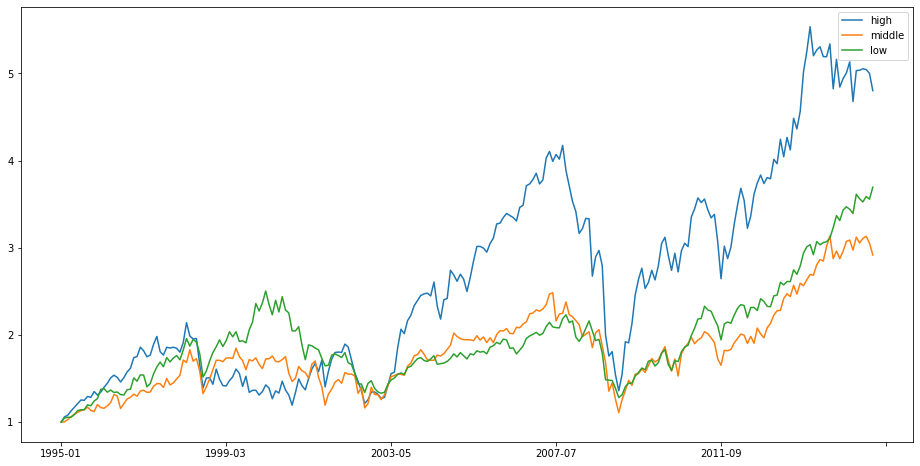

In [21]:
(df.pct_change().fillna(0) + 1).cumprod().plot(figsize=[16,8])